In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
%load_ext autoreload
import scipy

In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
#filename = "2023913_1110.h5"
filename = "20231129_ 952.h5" #minibife
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [03:33<00:00,  1.78s/it]


In [51]:
pro_data_norm=pro_data.copy()
#for i in range(0,pro_data.shape[0]):
 #   for j in range(0,pro_data.shape[1]):
  #      spec = 1 * pro_data[i,j, :]
   #     sum_spec=np.sum(spec)
    #    pro_data_norm[i,j,:]=spec/sum_spec

In [145]:
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

# threshold = 120
# threshold2 = 0.01

# # Scaled to max value for each wavenumber
# # masks = np.array([mask[:, i]*(mask[:, i] > threshold)/np.max(mask[:, i]) for i in range(mask.shape[-1])])
# masks = np.array([np.array((mask[:, i]/np.max(mask[:, i]))*((mask[:, i] > threshold)) > threshold2, dtype = int) for i in range(mask.shape[-1])])

In [146]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

In [147]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

In [148]:
mask_t.shape

(297, 9600)

## Cálculo da entropia

In [149]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mask_t)
mask_min_max=scaler.transform(mask_t)

In [150]:
mask_min_max=mask_min_max

In [151]:
print(mask_min_max.shape)
entropy_masks=mask_min_max*255

(297, 9600)


In [152]:
np.max(entropy_masks[8])

255.0

In [153]:
def entropy_calc(map_gr):
    import cv2
    from scipy.stats import entropy

    #image

    _bins = 200

    hist, _ = np.histogram(map_gr, bins=_bins, range=(0, _bins))

    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    return image_entropy

In [154]:

wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    #'Petalite':[491.3],
    'Quartz':[463.92],
    #'Spodumene':[704.5]
    'Muscovite':[263.2],
    'Lepidolite':[707] 
    
}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

<IPython.core.display.Javascript object>


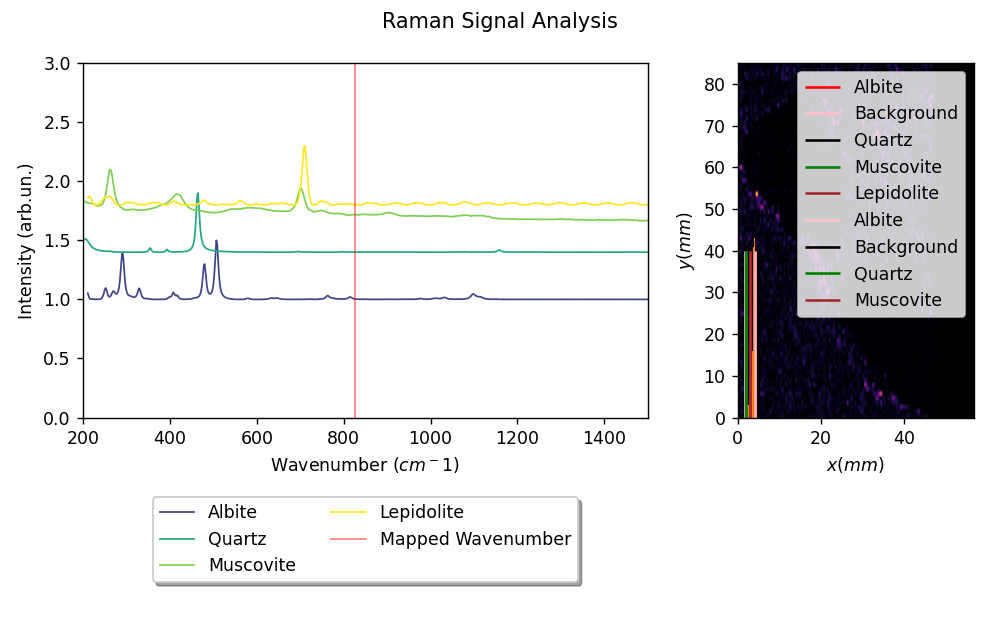

Albite
Background
Background not found
Quartz
Muscovite
Lepidolite


In [155]:
%matplotlib notebook
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]

for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(entropy_masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(entropy_masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [156]:
image_entropy=[]
for i in range(entropy_masks.shape[0]):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))


In [157]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

## Entropias intermédias é a que mantém mais informação - ajustar a gama

In [158]:
plt.hist(image_entropy,bins=20)
significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)
colors=['pink','black','green','brown']
significant_w.pop(1)
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

In [159]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)+0.2
min_en=np.min(relevant_entropies)-0.2
#min_en=5.2
#max_en=6.3

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)


C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<IPython.core.display.Javascript object>


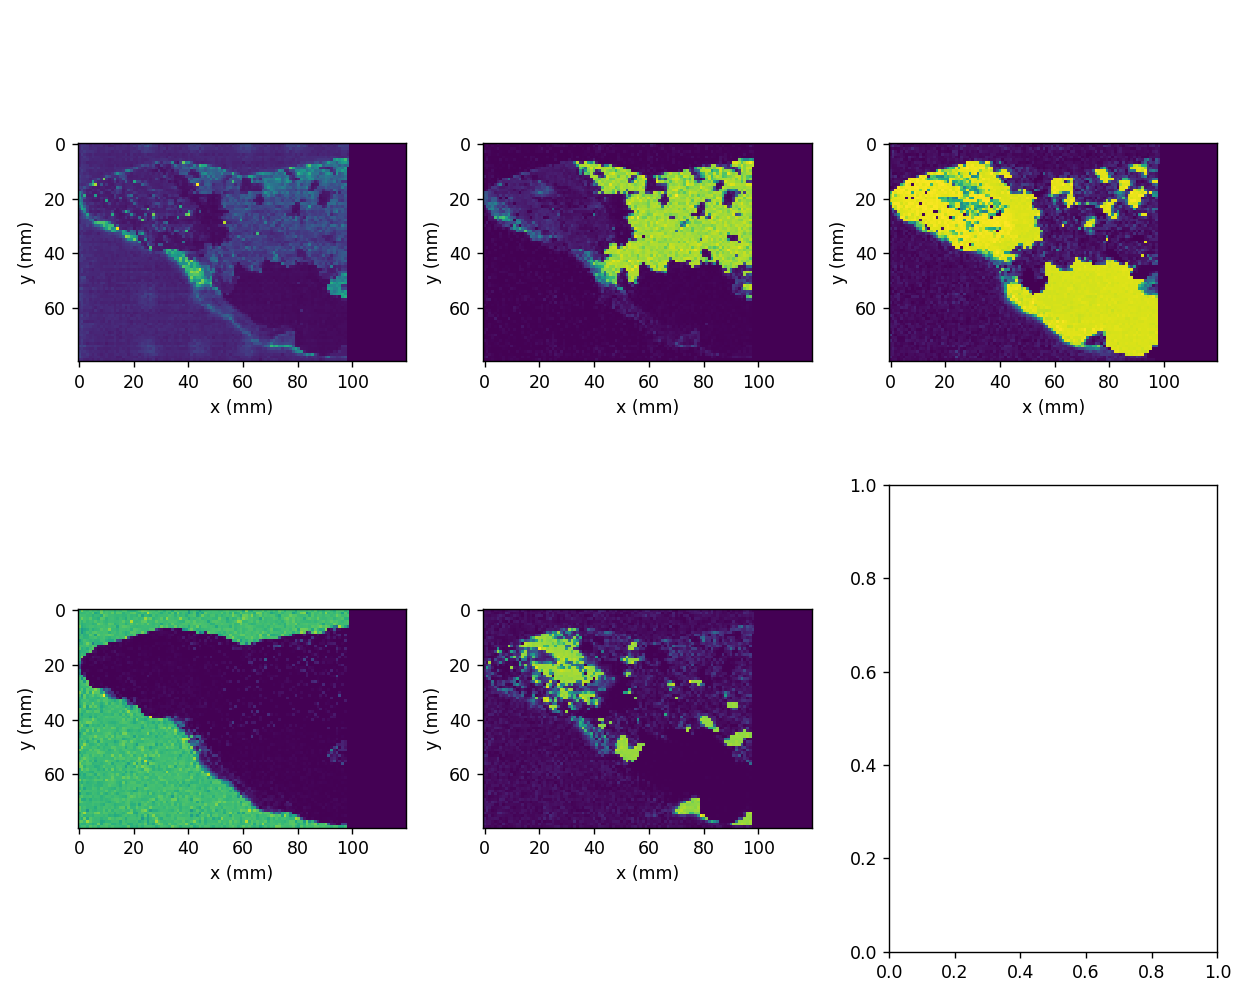

In [162]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<IPython.core.display.Javascript object>


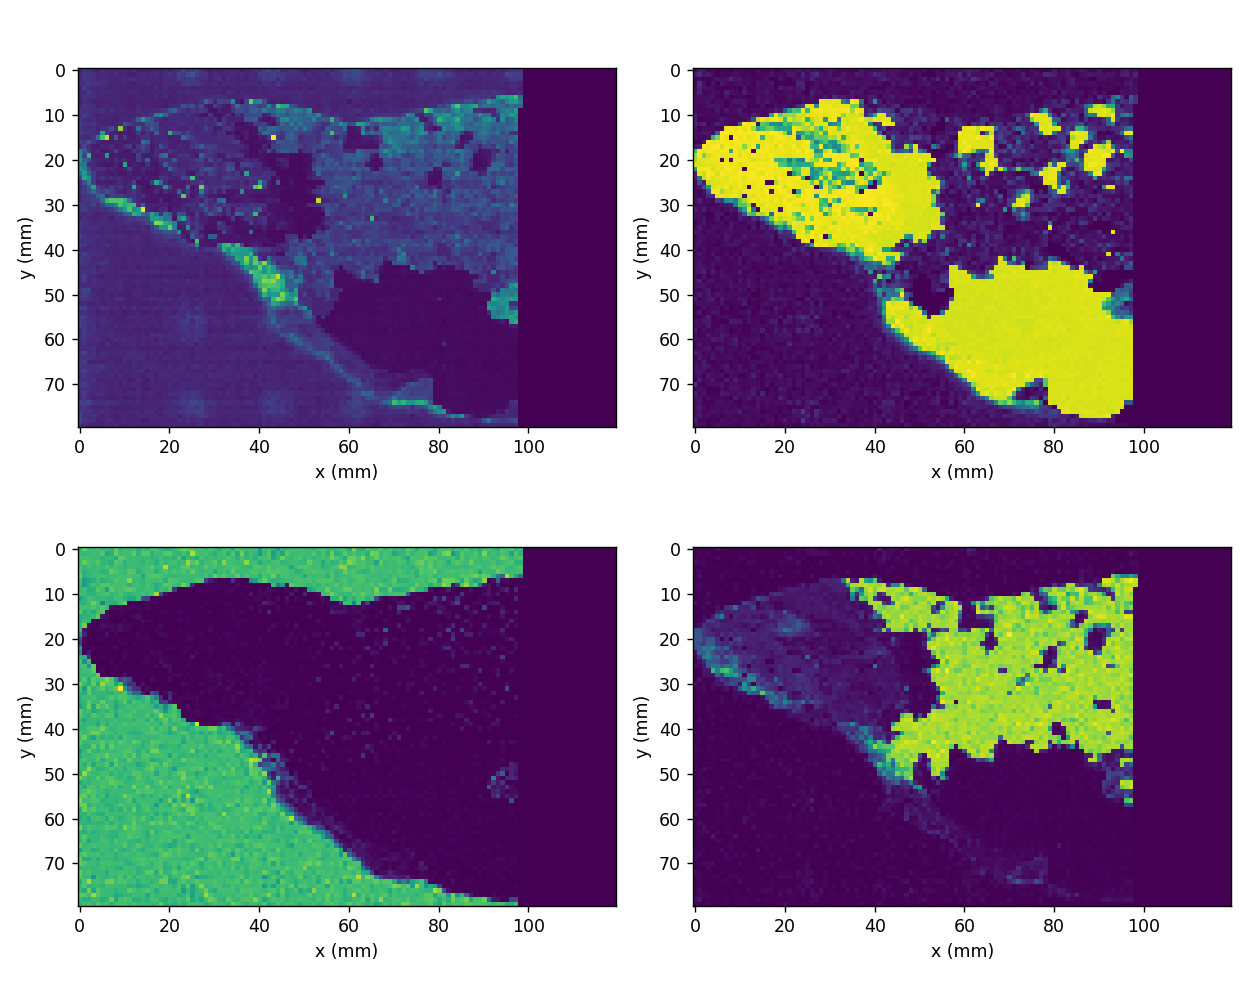

In [161]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 2, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()